# Convolutional Neural Networks
### Convolutional Neural Networks (CNNs) is a supervised learning algorithm designed to process structured grid-like data, such as images, by applying convolutional layers to extract spatial features, followed by fully connected layers for classification. It excels in classifying CIFAR-10 images (e.g., identifying categories like cats or airplanes based on pixel patterns) and can handle complex visual tasks, requiring extensive training to optimize filters and weights. The algorithm assumes that local spatial correlations exist in the data, which enables effective feature learning but may not hold for datasets with irregular or non-spatial structures. Its strength lies in its ability to capture hierarchical patterns in high-dimensional image data, but it can be computationally intensive, prone to overfitting without regularization, and sensitive to hyperparameter choices (e.g., filter size, learning rate).

### Use CNNs for image-based prototypes, with tuning oregularization to optimize performance, particularly for deployment in computer vision or autonomous systems.

| Aspect | Details |
| :- | :- |
| Use For           | Image classification (e.g., CIFAR-10 recognition, medical imaging)<br>Can be extended to object detection or segmentation |
| Key Assumptions   | - Local spatial correlations in the data<br>- Independent observations<br>- Sufficient data for filter optimization |
| Advantages        | - Extracts hierarchical spatial features<br>- Highly effective for image data<br>- Scalable with deep architectures |
| Disadvantages     | - Computationally intensive during training<br>- Prone to overfitting without regularization<br>- Sensitive to hyperparameter tuning |
| Avoid When        | - Non-spatial or unstructured datasets<br>- Very small datasets with limited samples<br>- Real-time applications with low latency |
| Real-World Use Case | CIFAR-10 image classification (e.g., identifying objects in photographs)<br>Medical imaging (e.g., detecting tumors in X-rays) |

## Problem Description: 
### Classify images from the CIFAR-10 dataset into one of 10 categories (e.g., airplane, cat, dog) based on pixel values. This is a multi-class classification problem where CNNs excel at extracting spatial features from image data.

Using Kaggle dataset https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

2025-06-13 19:24:45.973857: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 19:24:45.985107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749839085.997267 1409885 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749839086.000581 1409885 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749839086.010164 1409885 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def setup_gpu():
    ## tf version
    print("TensorFlow version:", tf.__version__)

    #### GPU Optimisation code ####
    print("GPUs:",tf.config.list_physical_devices('GPU'))

    print("GPUs: Allocate GPU Memory and create a new session")

    # Get the GPU memory fraction to allocate
    gpu_memory_fraction = 0.5

    # Create GPUOptions with the fraction of GPU memory to allocate
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)

    # Create a session with the GPUOptions
    session = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
setup_gpu()

TensorFlow version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: Allocate GPU Memory and create a new session


I0000 00:00:1749839088.385576 1409885 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5119 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:


# load CIFAR-10 dataset from original batch files on filesystem

project_dir = './14_cnn_convolutional_neural_network'

train_data = []
train_labels = []

data_dir = project_dir + '/data/'

for i in range(1, 6):  # Load 5 training batches
    batch_file = f'data_batch_{i}'
    batch_path = os.path.join(data_dir, batch_file)
    batch = unpickle(batch_path)
    train_data.append(batch[b'data'])
    train_labels.extend(batch[b'labels'])

X_train = np.vstack(train_data)
y_train = np.array(train_labels)

# load test batch
test_batch = unpickle(os.path.join(data_dir, 'test_batch'))
X_test = test_batch[b'data']
y_test = np.array(test_batch[b'labels'])

# preprocess the data
X_train = X_train.reshape((len(X_train), 3, 32, 32)).transpose(0, 2, 3, 1).astype('float32') / 255.0
X_test = X_test.reshape((len(X_test), 3, 32, 32)).transpose(0, 2, 3, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)



In [6]:
'''

# alternatively load the CIFAR-10 dataset through Keras
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("Training set shape:", X_train.shape, "Test set shape:", X_test.shape)

# preprocess the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

'''

'\n\n# alternatively load the CIFAR-10 dataset through Keras\n(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()\nprint("Training set shape:", X_train.shape, "Test set shape:", X_test.shape)\n\n# preprocess the data\nX_train = X_train.astype(\'float32\') / 255.0\nX_test = X_test.astype(\'float32\') / 255.0\ny_train = to_categorical(y_train, num_classes=10)\ny_test = to_categorical(y_test, num_classes=10)\n\n'

In [7]:
# split training data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("Train set shape:", X_train.shape, "Validation set shape:", X_val.shape, "Test set shape:", X_test.shape)

Train set shape: (40000, 32, 32, 3) Validation set shape: (10000, 32, 32, 3) Test set shape: (10000, 32, 32, 3)


In [8]:
# build the CNN model
cnn_model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    Dropout(0.1),  
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.1),  
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.1),  
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.1),  
    Dense(10, activation='softmax')  # output layer for 10 classes
])

# compile the model with a custom learning rate
custom_optimizer = Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.1)

# train the CNN model
history = cnn_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), 
                        callbacks=[early_stopping, reduce_lr], verbose=1)

/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749839089.571017 1409885 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5119 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/20


I0000 00:00:1749839092.833468 1410038 service.cc:152] XLA service 0x7fcfbc01da00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749839092.833552 1410038 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-06-13 19:24:52.864287: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749839093.070054 1410038 cuda_dnn.cc:529] Loaded cuDNN version 90300


 50/625 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1079 - loss: 2.3051

I0000 00:00:1749839095.599314 1410038 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.1742 - loss: 2.1908 - val_accuracy: 0.3618 - val_loss: 1.8182 - learning_rate: 1.0000e-04
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3361 - loss: 1.7981 - val_accuracy: 0.4170 - val_loss: 1.6395 - learning_rate: 1.0000e-04
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3911 - loss: 1.6408 - val_accuracy: 0.4498 - val_loss: 1.5519 - learning_rate: 1.0000e-04
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4188 - loss: 1.5737 - val_accuracy: 0.4668 - val_loss: 1.5062 - learning_rate: 1.0000e-04
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4528 - loss: 1.5070 - val_accuracy: 0.4906 - val_loss: 1.4321 - learning_rate: 1.0000e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4600 - loss: 1.4636 - val_accuracy: 0.5038 - val_loss: 1.3959 - learning_rate: 1.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4836 - lo

In [9]:
# predict and evaluate
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
class_report = classification_report(y_test_classes, y_pred_classes, output_dict=True, zero_division=1)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_report(y_test_classes, y_pred_classes, 
                            target_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.62
Confusion Matrix:
[[599  44  48  28  12   9  11  12 174  63]
 [ 34 723   5   9   4   4   9   6  56 150]
 [ 80  14 419 107 118  96  86  37  26  17]
 [ 17  12  60 468  63 183 106  42  24  25]
 [ 31   9  91  75 498  34 112 116  23  11]
 [ 14   6  65 215  39 533  40  62  15  11]
 [ 10   9  32  77  50  21 769  12   7  13]
 [ 15   6  20  67  63  84  12 673  10  50]
 [ 62  37  15  20   6   8   8   3 788  53]
 [ 25 114   7  13   3   7  17  18  59 737]]
Classification Report:
              precision    recall  f1-score   support

    airplane       0.68      0.60      0.63      1000
  automobile       0.74      0.72      0.73      1000
        bird       0.55      0.42      0.48      1000
         cat       0.43      0.47      0.45      1000
        deer       0.58      0.50      0.54      1000
         dog       0.54      0.53      0.54      1000
        frog       0.66      0.77      0.71      1000
       horse       0.69      0.67      

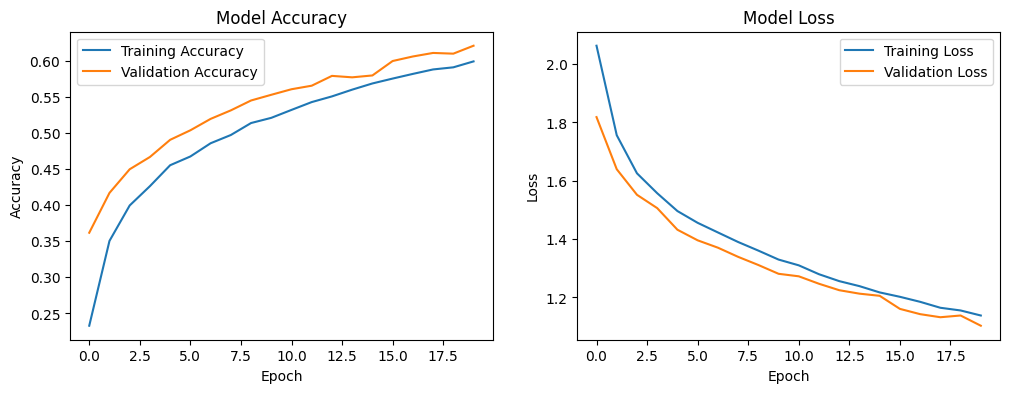

In [10]:
# visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

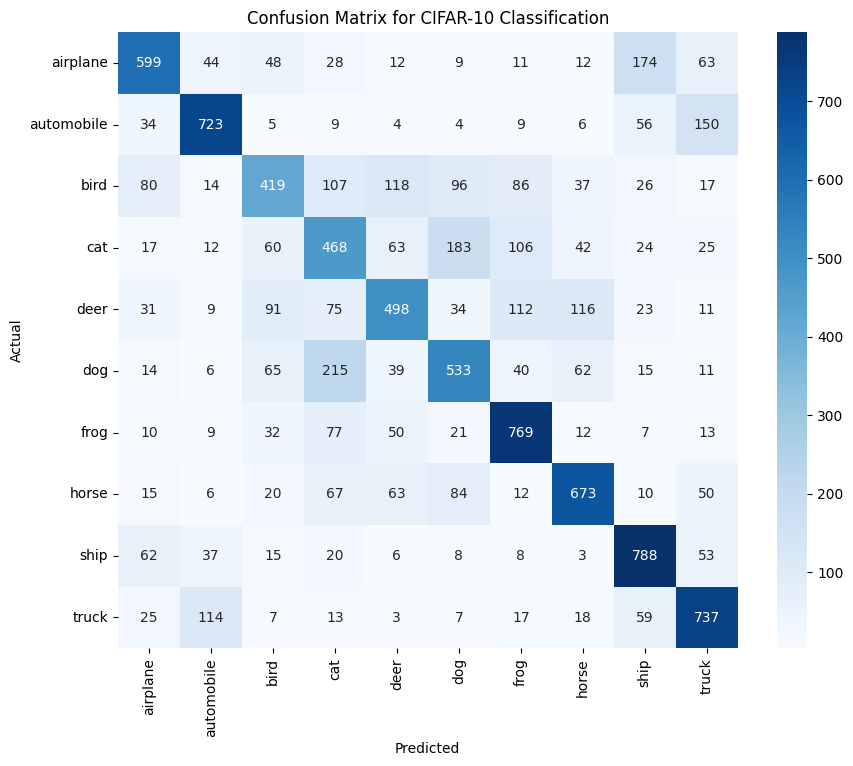

In [11]:
# visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], 
            yticklabels=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CIFAR-10 Classification')
plt.show()

In [12]:
# save the model and scaler in a 'model' subdirectory
model_dir = project_dir + '/model'
os.makedirs(model_dir, exist_ok=True)
model_filename = os.path.join(model_dir, 'cifar10_cnn_model.h5')
cnn_model.save(model_filename)
print(f'Model saved as {model_filename}')

Model saved as ./14_cnn_convolutional_neural_network/model/cifar10_cnn_model.h5


In [13]:
# load the PCA model 
loaded_model = tf.keras.models.load_model(model_filename)
sample_image = X_test[0:1]  # First test image
sample_prediction = loaded_model.predict(sample_image)
sample_prediction_class = np.argmax(sample_prediction, axis=1)
print(f'Predicted class for sample image: {sample_prediction_class[0]} {["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"][sample_prediction_class[0]]})')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
Predicted class for sample image: 3 cat)
